### Reproducing results 
This notebook reproduces deterministic soliton-soliton interactions specified in Kasssam-Trefethen 2005 initial conditions.

In [17]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
config.update("jax_enable_x64", True)

Specify initial setup of the signal, by first loading parameters from the stochastic traveling wave.

In [18]:
signal_params = ConfigDict(KDV_params)
print(signal_params)
#signal_params.update(E=1,method='Dealiased_ETDRK4',nx = 256,P=0,S=0) to update the parameters

Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 0
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 2.0e-06
equation_name: KdV
initial_condition: Kassam_Trefethen_KdV_IC_eq3pt1
method: Dealiased_ETDRK4
noise_magnitude: 0.0
nt: 5000
nx: 256
tmax: 0.01
xmax: 3.141592653589793
xmin: -3.141592653589793



In [19]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)

In [4]:
final, all = signal_model.run(initial_signal, signal_model.params.nt, None) #the final input is scan length? 

In [5]:
print(initial_signal.shape)
print(all.shape)
signal = jnp.concatenate([initial_signal[None,...], all], axis=0)

(1, 256)
(5000, 1, 256)


In [6]:
def plot(da_step):
    plt.plot(signal_model.x, signal[da_step,0,:], color='k')
    plt.legend(['signal'])
    plt.show()

interact(plot, da_step=(0, signal_model.params.nt))

interactive(children=(IntSlider(value=2500, description='da_step', max=5000), Output()), _dom_classes=('widget…

<function __main__.plot(da_step)>

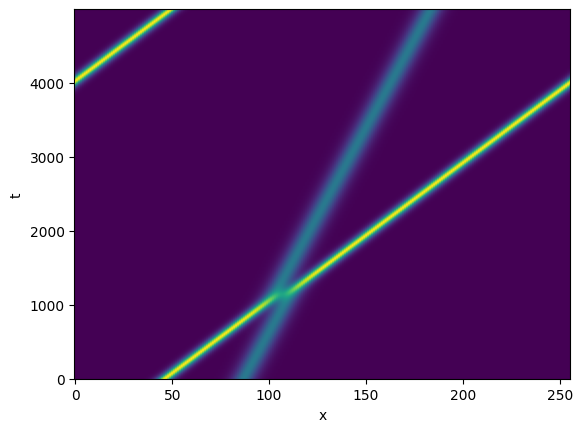

In [7]:
plt.imshow(all[:,0,:], aspect='auto',origin='lower')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

In [ ]:
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
from typing import List, Callable, Optional
import pickle


# ---- Fake KS-style data generator ----
def generate_data(N=64, steps=10, seed=0):
    key = jax.random.PRNGKey(seed)
    u0 = jax.random.normal(key, (N,))
    us = jnp.stack([u0 * jnp.exp(-0.1 * t) for t in range(1, steps + 1)], axis=0)
    return u0, us  # u0: (N,), us: (steps, N)

# ---- Fake KS-style data generator ----
def create_data(nx,steps,dt,seed=0):
    Tmax = steps*dt
    signal_params = ConfigDict(KDV_params)
    signal_params.update(nx=nx,dt=dt,nt=steps,tmax=Tmax)

    signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)# update after the reinitialization of params

    print(signal_model.params)
    
    initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
    final, all = signal_model.run(initial_signal, signal_model.params.nt, None)
    signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
    return signal[0,0,:], signal[1:,0,:]


# ---- Simple feedforward model ----
class Forecaster(eqx.Module):
    
    layer1: eqx.nn.Linear
    layer2: eqx.nn.Linear

    def __init__(self, width, key):
        key1, key2 = jax.random.split(key)
        self.layer1 = eqx.nn.Linear(width, width, key=key1)
        self.layer2 = eqx.nn.Linear(width, width, key=key2)

    def __call__(self, x):
        x = jax.nn.relu(self.layer1(x))
        return self.layer2(x)

class SimpleMLP(eqx.Module):
    layer1: eqx.nn.Linear
    layer2: eqx.nn.Linear
    layer3: eqx.nn.Linear

    def __init__(self, width, key):
        k1, k2, k3 = jax.random.split(key, 3)
        self.layer1 = eqx.nn.Linear(width, width, key=k1)
        self.layer2 = eqx.nn.Linear(width, width, key=k2)
        self.layer3 = eqx.nn.Linear(width, width, key=k3)

    def __call__(self, x):
        x = jax.nn.relu(self.layer1(x))
        x = jax.nn.relu(self.layer2(x))
        return self.layer3(x)

class SimpleFeedforward(eqx.Module):
    layer1: eqx.nn.Linear
    layer2: eqx.nn.Linear
    layer3: eqx.nn.Linear
    layer4: eqx.nn.Linear
    layer5: eqx.nn.Linear
    def __init__(self, width, key):
        key1, key2, key3, key4, key5 = jax.random.split(key, 5)
        self.layer1 = eqx.nn.Linear(width, width, key=key1)
        self.layer2 = eqx.nn.Linear(width, width, key=key2)
        self.layer3 = eqx.nn.Linear(width, width, key=key3)
        self.layer4 = eqx.nn.Linear(width, width, key=key4)  # Additional layer for deeper architecture
        self.layer5 = eqx.nn.Linear(width, width, key=key5)  # Additional layer for deeper architecture
    def __call__(self, x):
        x = jax.nn.relu(self.layer1(x))
        x = jax.nn.relu(self.layer2(x))
        x = jax.nn.relu(self.layer3(x))
        x = jax.nn.relu(self.layer4(x))
        x = self.layer5(x)  # No activation on output layer
        return x
    
# ---- Rollout function ----
def rollout(model, u0, steps):
    def step_fn(carry, _):
        u_next = model(carry)
        return u_next, u_next
    _, us = jax.lax.scan(step_fn, u0, None, length=steps)
    return us  # (steps, N)


# ---- Loss ----
def loss_fn(model, u0, u_true):
    u_pred = rollout(model, u0, u_true.shape[0])
    return jnp.mean((u_pred - u_true) ** 2)




@eqx.filter_value_and_grad
def compute_loss(model, u0, u_true):
    return loss_fn(model, u0, u_true)

@jax.jit
def train_step(model, opt_state, u0, u_true):
    loss, grads = compute_loss(model, u0, u_true)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


# ---- Main loop ----
nx = 64
steps = 100
dt = 0.00001  # Time step for the signal model
u0, u_true = create_data(nx = nx, steps=steps, dt=dt, seed=42)
print(f"Using initial signal shape: {u0.shape}, true signal shape: {u_true.shape}")
key = jax.random.PRNGKey(42)
#model = Forecaster(width=nx, key=key)
model = SimpleFeedforward(width=64, key=key)  # Use SimpleFeedforward instead of Forecaster
# ---- Training step ----
optimizer = optax.adam(1e-7)  # Using Adam optimizer with weight decay
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
for epoch in range(501):
    model, opt_state, loss = train_step(model, opt_state, u0, u_true)
    params = eqx.filter(model, eqx.is_inexact_array)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss = {loss:.6f}")




Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 0
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 1.0e-05
equation_name: KdV
initial_condition: Kassam_Trefethen_KdV_IC_eq3pt1
method: Dealiased_ETDRK4
noise_magnitude: 0.0
nt: 100
nx: 256
tmax: 0.001
xmax: 3.141592653589793
xmin: -3.141592653589793

Using initial signal shape: (256,), true signal shape: (100, 256)
Epoch 0: loss = 75292.745051
Epoch 100: loss = 75292.592317
Epoch 200: loss = 75292.445266
Epoch 300: loss = 75292.301171
Epoch 400: loss = 75292.158439
Epoch 500: loss = 75292.016174


In [16]:
optimizer = optax.adam(1e-1)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
for epoch in range(501):
    model, opt_state, loss = train_step(model, opt_state, u0, u_true)
    params = eqx.filter(model, eqx.is_inexact_array)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss = {loss:.6f}")

Epoch 0: loss = 75288.461403
Epoch 100: loss = 75288.325916
Epoch 200: loss = 75288.190395
Epoch 300: loss = 75288.055142
Epoch 400: loss = 75287.920128


KeyboardInterrupt: 

In [14]:
best_loss = float("inf")
best_params = params

for epoch in range(501):
    model, opt_state, loss = train_step(model, opt_state, u0, u_true)
    params = eqx.filter(model, eqx.is_inexact_array)
    if loss < best_loss:
        best_loss = loss
        best_params = params  # Save better parameters

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss = {loss:.6f} (best: {best_loss:.6f})")


Epoch 0: loss = 75288.945924 (best: 75288.945924)
Epoch 100: loss = 75288.808487 (best: 75288.808487)
Epoch 200: loss = 75288.670795 (best: 75288.670795)
Epoch 300: loss = 75288.532986 (best: 75288.532986)


KeyboardInterrupt: 

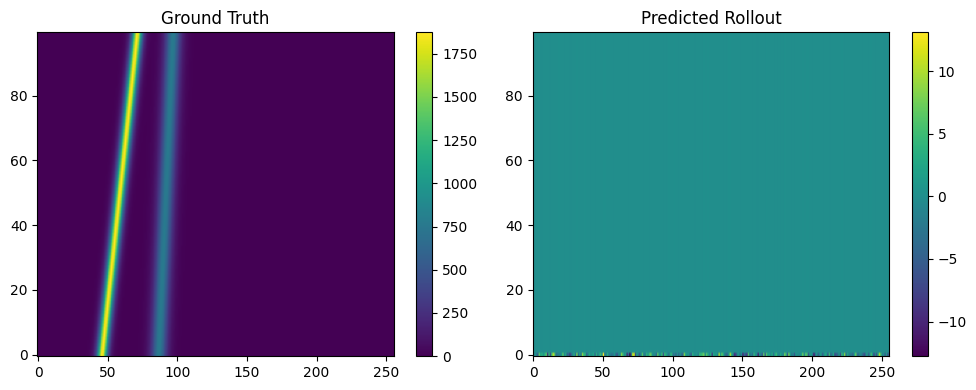

In [15]:
def plot_rollout(u_true, u_pred):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    im1 = axes[0].imshow(u_true, aspect='auto', origin='lower', cmap='viridis')
    axes[0].set_title("Ground Truth")
    fig.colorbar(im1, ax=axes[0])

    im2 = axes[1].imshow(u_pred, aspect='auto', origin='lower', cmap='viridis')
    axes[1].set_title("Predicted Rollout")
    fig.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()
    
u_pred = rollout(model, u0, steps)

plot_rollout(u_true, u_pred)


Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 0
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 0.0001
equation_name: KdV
initial_condition: Kassam_Trefethen_KdV_IC_eq3pt1
method: Dealiased_ETDRK4
noise_magnitude: 0.0
nt: 400
nx: 64
tmax: 0.04
xmax: 3.141592653589793
xmin: -3.141592653589793



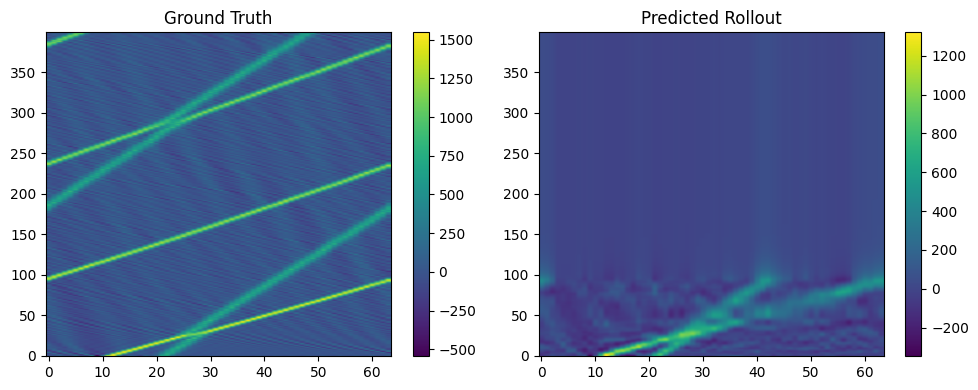

In [ ]:
N = 64
steps = 400
dt = 0.0001  # Time step for the signal model
u0, u_true_long = create_data(nx=N, steps=steps, dt=dt, seed=42)
u_pred = rollout(model, u0, steps)
plot_rollout(u_true_long, u_pred)




In [ ]:
import ipywidgets as widgets

u_true_long 
u_pred
def plot_comparison(step):
    plt.figure(figsize=(10, 4))
    plt.plot(u_true_long[step], label='Ground Truth')
    plt.plot(u_pred[step], label='Prediction')
    plt.title(f"Step {step}")
    plt.legend()
    plt.show()

widgets.interact(plot_comparison, step=(0, u_true_long.shape[0] - 1))

interactive(children=(IntSlider(value=199, description='step', max=399), Output()), _dom_classes=('widget-inte…

<function __main__.plot_comparison(step)>